## RL test task: MountainCarContinuous-v0

**[DDPG](https://arxiv.org/pdf/1509.02971.pdf) algorithm implementation**

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import copy
import random
import gym

import matplotlib.pyplot as plt
device = torch.device('cuda')

In [2]:
# agent's replay memory
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def append(self, elem):
        if len(self.memory) < self.capacity:
            self.memory.append(elem)
        self.memory[self.position] = elem
        self.position = (self.position + 1) % self.capacity
            
    def get_minibatch(self, size):
        return random.sample(self.memory, size)
    
    
    def __len__(self):
        return len(self.memory)

In [3]:
def exploit(model, render = True):
    state = env.reset()
    r = 0.
    is_terminal = False
    
    while not is_terminal:
        if render:
            env.render()
        action = model(torch.tensor(state).to(device).float().unsqueeze(0))[0].view(1, 1).item()
        state, reward, is_terminal, _ = env.step([action])
        r += reward
    return r

In [4]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(Actor, self).__init__()
        
        self.linear1 = nn.Linear(state_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def select_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().item()

In [5]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(state_size + action_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [6]:
def add_noise(action):
    action = np.clip(action + np.random.normal(0, 0.5, 1), -1, 1)
    return action

In [7]:
def optimize(batch):
    state, action, reward, next_state = batch
    
    state = torch.tensor(state).to(device).float()
    action = torch.tensor(action).to(device).float()
    reward = torch.tensor(reward).unsqueeze(1).to(device).float()
    next_state = torch.tensor(next_state).to(device).float()
    
    # critic loss
    next_action = target_actor(next_state).detach()
    target_q = target_critic(next_state, next_action)
    target_q = reward + GAMMA * target_q
    q = critic(state, action)
    critic_loss = F.mse_loss(q, target_q.detach())

    # actor loss
    predicted_action = actor(state)
    actor_loss = critic(state, predicted_action)
    actor_loss = -actor_loss.mean()
    
    # optimize critic
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    #optimize actor
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    # update target models
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)
        
    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

In [8]:
def train(actor, target_actor, actor_optimizer,
          critic, tatget_critic, critic_optimizer):
    
    reward_history = []
    replay_memory = Memory(MEMORY_CAPACITY)
    
    state = env.reset()
    
    for step in range(1, MAX_STEP):
        # select action
        action = actor.select_action(state)
        action = add_noise(action)
        
        # execute action
        new_state, reward, is_terminal, _ = env.step(action)
        
        # store observation in replay memory
        replay_memory.append((state,
                              action,
                              reward + 300 * (GAMMA * abs(new_state[1]) - abs(state[1])),
                              new_state))
        
        if is_terminal:
            state = env.reset()
            is_terminal = False
        else:
            state = new_state
        
        # gradient descent step
        if step > BATCH_SIZE:
            optimize(list(zip(*replay_memory.get_minibatch(BATCH_SIZE))))
        
        if step % UPDATE_STEP == 0:
            # exploitation
            r = exploit(actor, render = True)
            reward_history.append(r)
            
    return reward_history

In [9]:
# define constants
MAX_STEP = 100001
UPDATE_STEP = 1000

BATCH_SIZE = 128
MEMORY_CAPACITY = 10000

ACTOR_LR  = 1e-3
CRITIC_LR = 1e-4

GAMMA = 0.99
TAU = 1e-2

In [10]:
env = gym.make('MountainCarContinuous-v0')

actor  = Actor(2, 1, 256)
critic = Critic(2, 1, 256)

def init_model_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

actor.apply(init_model_weights)
critic.apply(init_model_weights)

target_actor  = copy.deepcopy(actor)
target_critic = copy.deepcopy(critic)

actor.to(device)
critic.to(device)
target_actor.to(device)
target_critic.to(device)

actor_optimizer  = optim.Adam(actor.parameters(), lr = ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr = CRITIC_LR)

In [11]:
rewards = train(actor, target_actor, actor_optimizer,
                critic, target_critic, critic_optimizer)

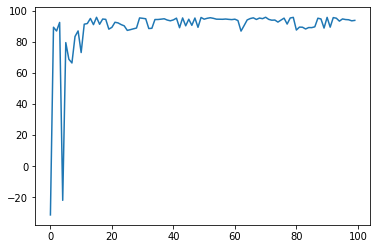

In [12]:
plt.plot(rewards)